### Quantum Reinforcement Learning in Cartpole environment of the gym

In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

/tmp/ipykernel_96474/1875984233.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/home/arshia/miniconda3/envs/tfq_env/lib/python3.8/site-packages/pkg_resources/__init__.py'>

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
tf.get_logger().setLevel('ERROR')

2024-03-24 14:38:49.294179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 14:38:52.411899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 14:38:52.412990: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 1. Build a PQC with data re-uploading

In [3]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [4]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))

    return circuit, list(params.flat), list(inputs.flat)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

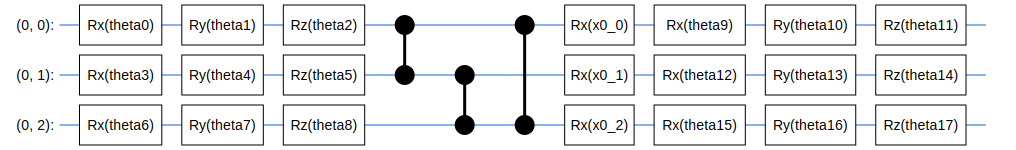

In [5]:
n_qubits, n_layers = 3, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

In [6]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

### 2. Policy Gradient RL with PQC policies

In [7]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [8]:
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 5 # Number of layers in the PQC
n_actions = 2 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)

In [9]:
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

In [10]:
def generate_model_policy(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC policy."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables)([input_tensor])
    process = tf.keras.Sequential([
        Alternating(n_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        tf.keras.layers.Softmax()
    ], name="observables-policy")
    policy = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=policy)

    return model

model = generate_model_policy(qubits, n_layers, n_actions, 1.0, observables)

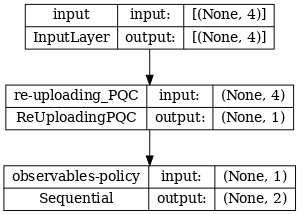

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [12]:
def gather_episodes(state_bounds, n_actions, model, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        # Compute policy for all unfinished envs in parallel
        states = tf.convert_to_tensor(normalized_states)
        action_probs = model([states])

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, policy in zip(unfinished_ids, action_probs.numpy()):
            action = np.random.choice(n_actions, p=policy)
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)

    return trajectories

In [13]:
def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [14]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 10
n_episodes = 1000

In [15]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

In [16]:
@tf.function
def reinforce_update(states, actions, returns, model):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    returns = tf.convert_to_tensor(returns)

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logits = model(states)
        p_actions = tf.gather_nd(logits, actions)
        log_probs = tf.math.log(p_actions)
        loss = tf.math.reduce_sum(-log_probs * returns) / batch_size
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

In [17]:
env_name = "CartPole-v1"

# Start training the agent
episode_reward_history = []
for batch in range(n_episodes // batch_size):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, model, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = np.concatenate([ep['states'] for ep in episodes])
    actions = np.concatenate([ep['actions'] for ep in episodes])
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = np.array(returns, dtype=np.float32)

    id_action_pairs = np.array([[i, a] for i, a in enumerate(actions)])

    # Update model parameters.
    reinforce_update(states, id_action_pairs, returns, model)

    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-10:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

Finished episode 10 Average rewards:  16.6
Finished episode 20 Average rewards:  21.3
Finished episode 30 Average rewards:  30.4
Finished episode 40 Average rewards:  23.7
Finished episode 50 Average rewards:  27.3
Finished episode 60 Average rewards:  38.7
Finished episode 70 Average rewards:  44.1
Finished episode 80 Average rewards:  57.0
Finished episode 90 Average rewards:  82.3
Finished episode 100 Average rewards:  57.3
Finished episode 110 Average rewards:  112.1
Finished episode 120 Average rewards:  132.7
Finished episode 130 Average rewards:  220.7
Finished episode 140 Average rewards:  241.5
Finished episode 150 Average rewards:  346.6
Finished episode 160 Average rewards:  401.2
Finished episode 170 Average rewards:  441.6
Finished episode 180 Average rewards:  469.1
Finished episode 190 Average rewards:  362.8
Finished episode 200 Average rewards:  360.1
Finished episode 210 Average rewards:  272.8
Finished episode 220 Average rewards:  228.9
Finished episode 230 Average 

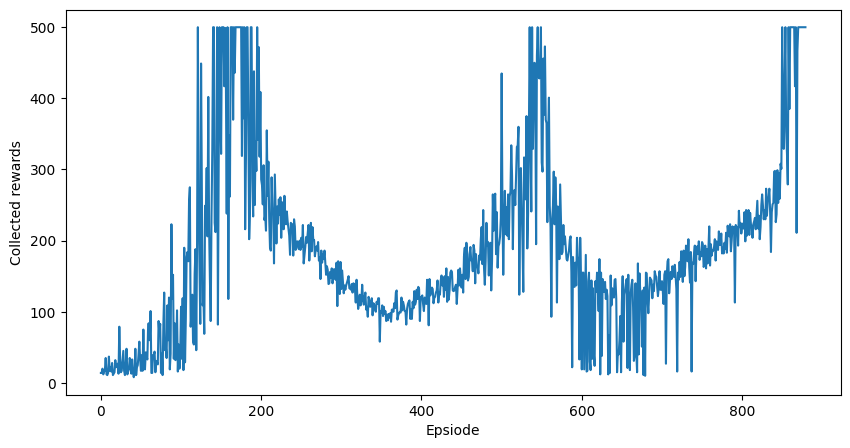

In [18]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

In [1]:
%env DISPLAY=:99


env: DISPLAY=:99


In [6]:
from PIL import Image
import pyglet 
#import pyglet.window

env = gym.make('CartPole-v1')
state = env.reset()
frames = []
for t in range(500):
    im = Image.fromarray(env.render(mode='rgb_array'))
    frames.append(im)
    policy = model([tf.convert_to_tensor([state/state_bounds])])
    action = np.random.choice(n_actions, p=policy.numpy()[0])
    state, _, done, _ = env.step(action)
    if done:
        break
env.close()
frames[1].save('./images/gym_CartPole.gif',
               save_all=True, append_images=frames[2:], optimize=False, duration=40, loop=0)

NameError: name 'base' is not defined

In [3]:
from PIL import Image
import gym
import numpy as np
import matplotlib.pyplot as plt

# a dummy environment wrapper that bypasses the rendering in 'human' mode
class DummyEnv(gym.Wrapper):
    def render(self, mode='human', **kwargs):
        if mode == 'rgb_array':
            return super().render(mode=mode, **kwargs)
        else:
            return np.array([])  


env = DummyEnv(gym.make('CartPole-v1'))
state = env.reset()
frames = []

for t in range(500):
    # RGB array representation of the environment state
    rgb_array = env.render(mode='rgb_array')
    frames.append(Image.fromarray(rgb_array))

    
    policy = model([tf.convert_to_tensor([state/state_bounds])])
    action = np.random.choice(n_actions, p=policy.numpy()[0])
    state, _, done, _ = env.step(action)
    if done:
        break

# frames saved as an animated GIF
frames[0].save('gym_animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=40, loop=0)

env.close()


libGL error: MESA-LOADER: failed to open iris: /home/arshia/miniconda3/envs/tfq_env/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /home/arshia/miniconda3/envs/tfq_env/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /lib/x86_64-linux-gnu/libLLVM-15.so.1) (search paths /usr/lib/x86_64-linux-gnu/dri, suffix _dri)
libGL error: failed to load driver: swrast


ContextException: Could not create GL context

In [2]:
%env LIBGL_ALWAYS_SOFTWARE


UsageError: Environment does not have key: LIBGL_ALWAYS_SOFTWARE


In [1]:
%env LIBGL_DRIVERS_PATH


'/usr/lib/x86_64-linux-gnu/dri'

### 3. Deep Q-learning with PQC Q-function approximators

In [30]:
class Rescaling(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(Rescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.math.multiply((inputs+1)/2, tf.repeat(self.w,repeats=tf.shape(inputs)[0],axis=0))

In [32]:
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 5 # Number of layers in the PQC
n_actions = 2 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [ops[0]*ops[1], ops[2]*ops[3]] # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1

In [33]:
def generate_model_Qlearning(qubits, n_layers, n_actions, observables, target):
    """Generates a Keras model for a data re-uploading PQC Q-function approximator."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables, activation='tanh')([input_tensor])
    process = tf.keras.Sequential([Rescaling(len(observables))], name=target*"Target"+"Q-values")
    Q_values = process(re_uploading_pqc)
    model = tf.keras.Model(inputs=[input_tensor], outputs=Q_values)

    return model

model = generate_model_Qlearning(qubits, n_layers, n_actions, observables, False)
model_target = generate_model_Qlearning(qubits, n_layers, n_actions, observables, True)

model_target.set_weights(model.get_weights())

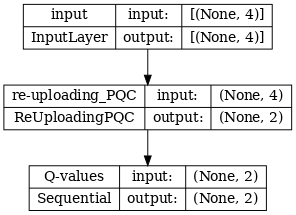

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [35]:
def interact_env(state, model, epsilon, n_actions, env):
    # Preprocess state
    state_array = np.array(state) 
    state = tf.convert_to_tensor([state_array])

    # Sample action
    coin = np.random.random()
    if coin > epsilon:
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else:
        action = np.random.choice(n_actions)

    # Apply sampled action in the environment, receive reward and next state
    next_state, reward, done, _ = env.step(action)

    interaction = {'state': state_array, 'action': action, 'next_state': next_state.copy(),
                   'reward': reward, 'done':np.float32(done)}

    return interaction

In [36]:
@tf.function
def Q_learning_update(states, actions, rewards, next_states, done, model, gamma, n_actions):
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute their target q_values and the masks on sampled actions
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1)
                                                   * (1.0 - done))
    masks = tf.one_hot(actions, n_actions)

    # Train the model on the states and target Q-values
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_values = model([states])
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

In [37]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

In [38]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

In [39]:
env = gym.make("CartPole-v1")

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state = env.reset()

    while True:
        # Interact with env
        interaction = interact_env(state, model, epsilon, n_actions, env)

        # Store interaction in the replay memory
        replay_memory.append(interaction)

        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1

        # Update model
        if step_count % steps_per_update == 0:
            # Sample a batch of interactions and update Q_function
            training_batch = np.random.choice(replay_memory, size=batch_size)
            Q_learning_update(np.asarray([x['state'] for x in training_batch]),
                              np.asarray([x['action'] for x in training_batch]),
                              np.asarray([x['reward'] for x in training_batch], dtype=np.float32),
                              np.asarray([x['next_state'] for x in training_batch]),
                              np.asarray([x['done'] for x in training_batch], dtype=np.float32),
                              model, gamma, n_actions)

        # Update target model
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())

        # Check if the episode is finished
        if interaction['done']:
            break

    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    if (episode+1)%10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(
            episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break

Episode 10/2000, average last 10 rewards 22.9
Episode 20/2000, average last 10 rewards 27.4
Episode 30/2000, average last 10 rewards 20.4
Episode 40/2000, average last 10 rewards 25.1
Episode 50/2000, average last 10 rewards 28.3
Episode 60/2000, average last 10 rewards 48.8
Episode 70/2000, average last 10 rewards 39.6
Episode 80/2000, average last 10 rewards 21.2
Episode 90/2000, average last 10 rewards 34.1
Episode 100/2000, average last 10 rewards 44.4
Episode 110/2000, average last 10 rewards 49.9
Episode 120/2000, average last 10 rewards 45.6
Episode 130/2000, average last 10 rewards 67.7
Episode 140/2000, average last 10 rewards 64.7
Episode 150/2000, average last 10 rewards 57.0
Episode 160/2000, average last 10 rewards 64.1
Episode 170/2000, average last 10 rewards 73.6
Episode 180/2000, average last 10 rewards 73.9
Episode 190/2000, average last 10 rewards 76.1
Episode 200/2000, average last 10 rewards 85.8
Episode 210/2000, average last 10 rewards 97.6
Episode 220/2000, aver

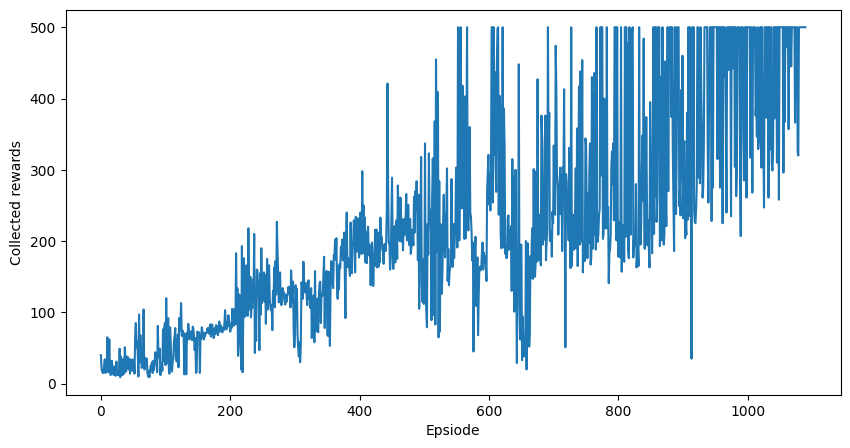

In [40]:
plt.figure(figsize=(10,5))
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()